# Metric evaluation
The goal of this notebook is to evaluate Impact factor vs other metrics as a way of modeling card strength.  Card strength is approximated by the [Qvist rankings](http://wiki.dominionstrategy.com/index.php/List_of_Cards_by_Qvist_Rankings), which are based on community voting.

In [230]:
#packages
import os
import re
import pdb
import numpy as np
import pickle
import time
import pandas as pd
from bs4 import BeautifulSoup
from urllib import request as rq
import matplotlib.pyplot as plt

## Scraping Qvist rankings

In [3]:
wiki = "http://wiki.dominionstrategy.com/index.php/List_of_Cards_by_Qvist_Rankings"
page = rq.urlopen(wiki)
soup = BeautifulSoup(page,"lxml")

In [174]:
#get list of tables
tables = soup.findAll("table", { "class" : "wikitable sortable" })

In [175]:
#get list of card names and make a dataFrame
cardNames = []
for table in tables:
    cardRows = table.findAll("tr")[1:]
    for i in range(len(cardRows)):
        cardNames.append(cardRows[i].findAll("td")[0].get_text().strip())

qvist = pd.DataFrame({'Card': cardNames})

In [176]:
#get ranking data, ignoring the +/- columns
qvist['Set'] = ''
qvist['Category'] = ''
categories = ['0-2 cost','3 cost','4 cost','5 cost','6+ cost','Potion cost','Ruins','Knights','Prizes','Landmarks','Events','Projects','Boons','Hexes']

curr_index = 0
for k in range(len(tables)):
    rows = tables[k].findAll("tr")
    colTitles = rows[0].findAll("th")
    isYear = [False]*len(colTitles)
    for i in range(len(colTitles)):
        colTitles[i] = colTitles[i].string.strip()
        
        #If the column is a year, and not already in the data frame, add it.
        m = re.match("(20\d\d)",colTitles[i])
        if(m):
            isYear[i] = True
            if colTitles[i] not in qvist.columns:
                qvist[colTitles[i]] = np.nan
    
    #go through each row and add the ranking data
    for j in range(1,len(rows)):
        cells = rows[j].findAll("td")
        cardName = cells[0].get_text().strip()
        qvist.iloc[curr_index,qvist.columns.get_loc('Category')] = categories[k]
        for i in range(len(colTitles)):
            if(isYear[i]):
                try:
                    rank = int(cells[i].get_text().strip())
                    qvist.iloc[curr_index,qvist.columns.get_loc(colTitles[i])] = rank
                except ValueError:
                    pass
            if colTitles[i] == 'Release':
                qvist.iloc[curr_index,qvist.columns.get_loc('Set')] = cells[i].get_text().strip()
        curr_index += 1

In [177]:
qvist.head()

,Card,Set,Category,2011,2012,2013,2014,2015,2016,2017,2018
0,Peasant,Adventures,0-2 cost,NaN,NaN,NaN,NaN,3.0,3.0,2.0,1.0
1,Chapel,Base,0-2 cost,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
2,Page,Adventures,0-2 cost,NaN,NaN,NaN,NaN,2.0,2.0,3.0,3.0
3,Encampment,Empires,0-2 cost,NaN,NaN,NaN,NaN,NaN,12.0,5.0,4.0
4,Monastery,Nocturne,0-2 cost,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0


In [178]:
#save as csv
qvist.to_csv('qvist_rankings.csv')

## Procedure for evaluating a metric
To evaluate a metric, the idea is to calculate the correlation coefficient when one ranking is plotted against another.  However, there's a complication: the Qvist rankings are broken up into several lists.  So the idea is to calculate the correlation coefficient for each list, and calculate an average weighted by the number of cards in each list.

Another minor complication is that the format of the rankings files is a bit different, but that's easy to address.

In [203]:
impact = pd.read_csv('impact_rankings.csv')
qvist = pd.read_csv('qvist_rankings.csv')

In [180]:
#first, we need to make sure that the spelling of each card is consistent in the two databases
#so let's find any cards in the impact rankings which are not present in the qvist rankings
oddities = []
for card in impact['Card']:
    if(not any(qvist['Card'] == card)):
        oddities.append(card)
print(oddities)

['JackOfAllTrades', 'Colony', 'Platinum', 'Ruins', 'Potion', 'Copper', 'Duchy', 'Silver', 'Gold', 'Curse', 'Province', 'Estate']


In [204]:
#the non-kingdom cards don't really matter, but the spelling of Jack of all Trades must be corrected
def correct_rankings(ranking):
    joat_index = np.where(impact['Card'] == 'JackOfAllTrades')[0][0]
    ranking.loc[joat_index,'Card'] = 'Jack of all Trades'
    #non_kingdom_cards = ['Colony', 'Platinum', 'Ruins', 'Potion', 'Copper', 'Duchy', 'Silver', 'Gold', 'Curse', 'Province', 'Estate']
    #for card in non_kingdom_cards:
    #    index = np.where(impact['Card'] == card)[0][0]
    #    ranking = ranking.drop(index)
    return ranking

In [205]:
impact = correct_rankings(impact)

In [228]:
#Now, let's take a look at the 0-2 cost rankings for 2014
#my intention is to code this into a more general function after testing
category = '0-2 cost'
year = '2014'
metric = impact

#take the relevant subset of qvist rankings
qvist_compare = qvist[np.logical_and(qvist['Category'] == category,np.logical_not(np.isnan(qvist[year])))]
qvist_compare.reset_index(inplace=True,drop=True)

#we only care about the cards that overlap with our impact data set
overlap = [card in metric['Card'].tolist() for card in qvist_compare['Card']]

#the overlap is 100% for 2014, but might have some false values in other cases
qvist_compare = qvist_compare[overlap]
qvist_compare.reset_index(inplace=True,drop=True)

#next we take the relevant subset of the metric-based rankings
overlap = [card in qvist_compare['Card'].tolist() for card in metric['Card']]
metric_compare = metric[overlap]
metric_compare.reset_index(inplace=True,drop=True)

#now join this with qvist rankings
qvist_compare['Metric ranking'] = np.nan
for i,card in zip(qvist_compare.index,qvist_compare['Card']):
    qvist_compare.loc[i,'Metric ranking'] = np.where(metric_compare['Card'] == card)[0][0]+1
    

In [231]:
#it would be nice to have a quick plot the qvist rankings against the impact rankings
%matplotlib inline

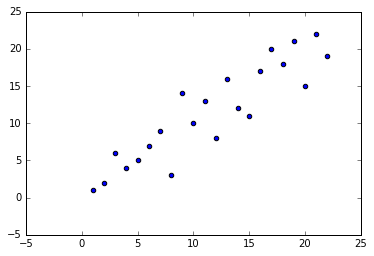

In [237]:
plt.scatter(qvist_compare['Metric ranking'], qvist_compare['2014'])

In [ ]:
#next, let's generalize it to any category

In [258]:
#reload module
import sys
if 'analysis_functions' in sys.modules:
    del sys.modules['analysis_functions']
from analysis_functions import *

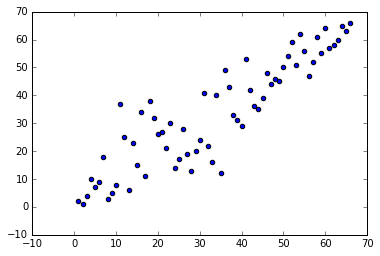

In [250]:
qvist_compare = compare_to_qvist(impact,qvist,'5 cost','2014')
plt.scatter(qvist_compare['Metric ranking'], qvist_compare['2014'])

In [252]:
#calculate correlation coefficient
np.corrcoef(qvist_compare['Metric ranking'], qvist_compare['2014'])[0,1]

0.8966704936854193

In [259]:
#Now calculate a weighted average of the correlation coefficient for all categories
#well not quite all categories, just the important ones.  Don't care about ruins or knights
score_metric(impact,qvist,'2014')

0.8633299948314384

## Comparing different metrics
I want to compare 4 different metrics.  The first three are the impact factor, synergy factor, and an alternative version of impact factor that looks at total number of gains instead of gain frequency.  The last metric is simply gain percentage (which is the most commonly used metric by the Dominion community).  My intuition is that impact factor is the best one, but we'll find out!

In [264]:
#I haven't calculated the gain percentages yet, but those are easy enough
num_games, game_gains, total_gains, card_list, card_dict = init_data()
gain_prc = [game_gains[i,i]/num_games[i,i] for i in range(game_gains.shape[0])]
gain_prc_sorted = sort_metric( gain_prc, card_list, card_dict )
gain_prc_sorted.to_csv('gain_percentage_rankings.csv')

In [276]:
#reload module
import sys
if 'analysis_functions' in sys.modules:
    del sys.modules['analysis_functions']
from analysis_functions import *

In [273]:
#load files
impact = pd.read_csv('impact_rankings.csv')
impact_alt = pd.read_csv('total_gain_impact_rankings.csv')
synergy = pd.read_csv('synergy_rankings.csv')
gain_prc = pd.read_csv('gain_percentage_rankings.csv')
qvist = pd.read_csv('qvist_rankings.csv')

In [274]:
impact = correct_rankings(impact)
impact_alt = correct_rankings(impact_alt)
synergy = correct_rankings(synergy)
gain_prc = correct_rankings(gain_prc)

In [281]:
def print_scores(year):
    print('Year %s' % year)
    print('Impact score:')
    print(score_metric(impact,qvist,year))
    print('Total gain impact score:')
    print(score_metric(impact_alt,qvist,year))
    print('Synergy score:')
    print(score_metric(synergy,qvist,year))
    print('Gain percentage score:')
    print(score_metric(gain_prc,qvist,year))

In [282]:
print_scores('2014')

Year 2014
Impact score:
0.8633299948314384
Total gain impact score:
0.7934680519693003
Synergy score:
0.8272227241081889
Gain percentage score:
0.8461272092107612


Yup!  The impact rankings are very slightly better than the gain percentage rankings!

Just for fun, let's calculate the scores for other years.

In [283]:
print_scores('2013')

Year 2013
Impact score:
0.8083565654479714
Total gain impact score:
0.754636086206295
Synergy score:
0.7680147239715113
Gain percentage score:
0.7866440041567063


In [289]:
print_scores('2015')

Year 2015
Impact score:
0.8350122890218269
Total gain impact score:
0.760897602988807
Synergy score:
0.7982946266768716
Gain percentage score:
0.8401618917603081
